# Dimensionality reduction

## Feature selection

<div class="alert alert-info">Read our dataset.</div>

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest



# Load the dataset from the provided URL
data = pd.read_csv("https://raw.githubusercontent.com/gnapoles/data-mining-course/main/diabetes.csv")

# Let's min-max normalize the data
data = (data - data.min()) / (data.max() - data.min())

# Specify the target variable name (replace 'target_name' with the actual name)
target_name = 'Outcome'

# Extract the feature columns and target variable
X = data.drop(columns=[target_name])
y = data[target_name]


<div class="alert alert-info">Information gain.</div>

In [3]:
from sklearn.feature_selection import f_regression
# Calculate the correlation between each feature and the target variable
correlation_scores = []
for column in X.columns:
    correlation_score = np.corrcoef(X[column], y)[0, 1]
    correlation_scores.append((column, abs(correlation_score)))

# Sort the features by their correlation scores in descending order
correlation_scores.sort(key=lambda x: x[1], reverse=True)

# Select the top k features based on correlation scores
k = 3  # Number of features to select
selected_features = [score[0] for score in correlation_scores[:k]]

# Create a new DataFrame with the selected features
X_selected = X[selected_features]

# Print the selected feature names
print("Selected feature names:", selected_features)


Selected feature names: ['Glucose', 'BMI', 'Age']


<div class="alert alert-info">Chi-Squared Feature Selection.</div>

In [6]:
from sklearn.feature_selection import chi2

# Select the top k features based on chi-squared test
k = 4  # Number of features to select
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Print the selected feature names
selected_feature_names = X.columns[selected_feature_indices]
print("Selected feature names:", selected_feature_names)


Selected feature names: Index(['Pregnancies', 'Glucose', 'DiabetesPedigreeFunction', 'Age'], dtype='object')


<div class="alert alert-warning">Exercise 1:What are the four top features based on Chi square error measure?</div>

<div class="alert alert-info">Correlation-based feature selection.</div>

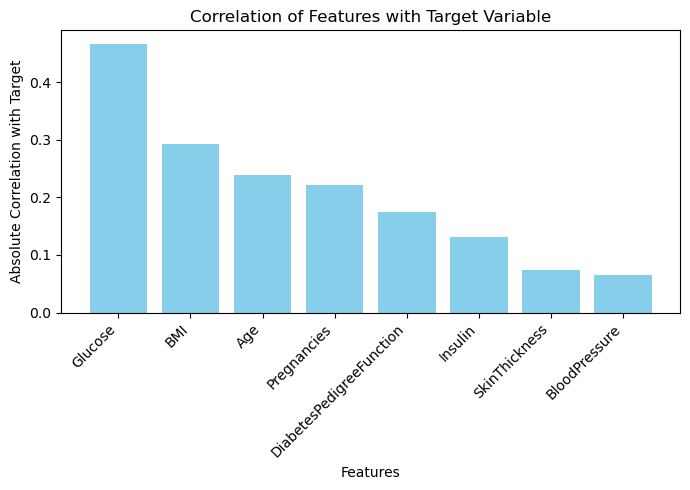

In [7]:
import matplotlib.pyplot as plt

# Calculate the correlation between each feature and the target variable
correlation_with_target = X.apply(lambda col: col.corr(pd.Series(y)), axis=0)

# Sort features by their correlation with the target
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

# Visualize the correlations
plt.figure(figsize=(7, 5))
plt.bar(correlation_with_target.index, correlation_with_target, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation with Target')
plt.title('Correlation of Features with Target Variable')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<div class="alert alert-warning">Exercise 2:Given the plot, if a data scientist decides to train a model with 7 features which features can be safely removed?</div>

## Wrapper methods

<div class="alert alert-info">Forward feature selection.</div>

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize variables to keep track of selected features and their indices
selected_features = []
selected_feature_indices = []
best_accuracy = 0

# Create a logistic regression model as an example classifier
clf = LogisticRegression(solver='liblinear', random_state=42)

while len(selected_features) < len(X.columns):
    # Initialize variables to keep track of the best feature and accuracy
    best_feature = None
    best_feature_accuracy = 0
    
    # Iterate over remaining features
    for feature_idx, feature_name in enumerate(X.columns):
        if feature_idx not in selected_feature_indices:
            # Add the feature to the selected set
            current_feature_indices = selected_feature_indices + [feature_idx]
            current_features = X_train.iloc[:, current_feature_indices]
            
            # Train the model on the current set of features
            clf.fit(current_features, y_train)
            
            # Make predictions on the test set
            current_test_features = X_test.iloc[:, current_feature_indices]
            y_pred = clf.predict(current_test_features)
            
            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            
            # Check if this is the best feature so far
            if accuracy > best_feature_accuracy:
                best_feature = feature_name
                best_feature_accuracy = accuracy
                best_feature_idx = feature_idx
    
    # Add the best feature to the selected features and indices
    selected_features.append(best_feature)
    selected_feature_indices.append(best_feature_idx)
    
    # Update the best accuracy if necessary
    if best_feature_accuracy > best_accuracy:
        best_accuracy = best_feature_accuracy
    else:
        # If adding more features doesn't improve accuracy, break the loop
        break

print("Selected features:", selected_features)
print("Best accuracy:", best_accuracy)


Selected features: ['Glucose', 'Pregnancies', 'DiabetesPedigreeFunction', 'BMI', 'Insulin']
Best accuracy: 0.8246753246753247


<div class="alert alert-info">Recursive feature elimination.</div>

In [9]:

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Create a linear regression model (or any other model of your choice)
model = LinearRegression()

# Create an RFE (Recursive Feature Elimination) selector with the model
rfe = RFE(model, n_features_to_select=3)  # You can specify the number of features to select

# Fit the RFE selector on your data
fit = rfe.fit(X, y)

# Get the selected features and their rankings
selected_features = fit.support_


sel_wrapper = pd.DataFrame([list(fit.support_)], columns=data.columns[:-1])
sel_wrapper.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,True,True,False,False,False,True,False,False


<div class="alert alert-warning">Exercise 3:  what are the most informative subset of feature using RFE method?</div>

<div class="alert alert-info">Embedded Methods.</div>

In [10]:
from sklearn.linear_model import Lasso

In [11]:
lasso = Lasso(alpha=0.01)
lasso.fit(X,y)

sel_embedded = pd.DataFrame([list(lasso.coef_)], columns=data.columns[:-1])
sel_embedded.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.167692,0.935508,-0.0,0.0,0.0,0.17376,0.0,0.021214


In the table above (visualized as a DataFrame), we can see the regression coefficients. According to the results, the most important features are glucose, BMI and pregnancies. Next, we can filter the data and build our classifier using these features only.

<div class="alert alert-info">PCA.</div>

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

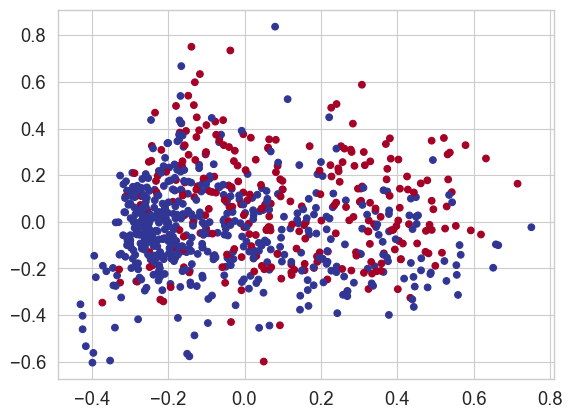

In [13]:
pca = PCA(n_components=2)
proj = pca.fit_transform(X)
plot = plt.scatter(proj[:, 0], proj[:, 1], c=y, cmap='RdYlBu_r')

<div class="alert alert-warning">Exercise 4:Check the manual.</div>

<div class="alert alert-success">Practice with MNIST dataset</div>

In [14]:
#Load libraries
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np


In [15]:
# Load a subset of the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data[:500]  # Using first 1000 examples for faster computation

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)


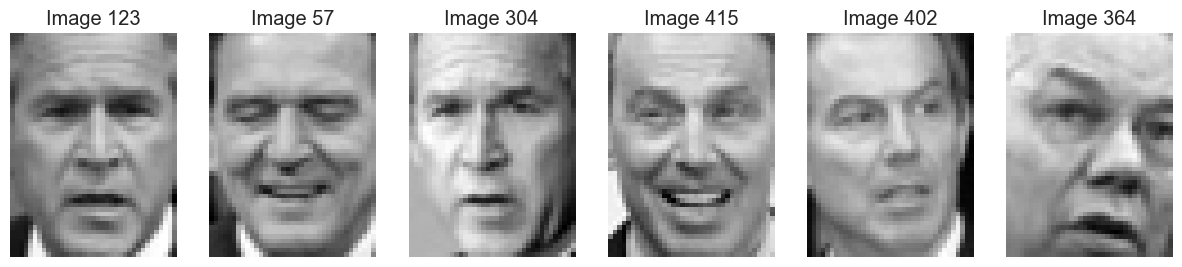

In [16]:
# Now, visualize six random images from the original dataset
images = lfw_people.images[:500] # Images for visualization
fig, ax = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    idx = np.random.randint(0, images.shape[0])
    ax[i].imshow(images[idx], cmap=plt.cm.gray)
    ax[i].set_title(f'Image {idx}')
    ax[i].axis('off')

plt.show()

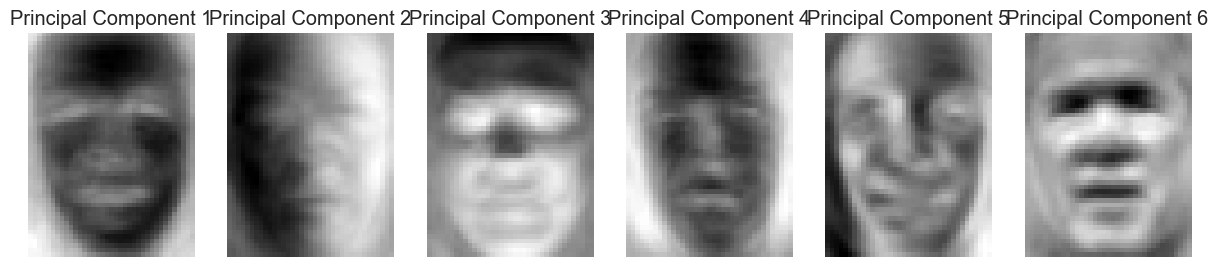

In [17]:
# Apply PCA to extract the top six components
pca = PCA(n_components=6)
pca.fit(X_std)

# Visualize the principal components as images
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
components = pca.components_.reshape((6, h, w))

for i, component in enumerate(components):
    axes[i].imshow(component, cmap=plt.cm.gray)
    axes[i].set_title(f'Principal Component {i+1}')
    axes[i].axis('off')

plt.show()

<div class="alert alert-warning">Answer the following questions using the code:</div>

<div class="alert alert-warning">Exercise 5: Is PCA a supervised method?</div>

<div class="alert alert-warning">Exercise 6: Do PCs carry interpretable semantic information?</div>

<div class="alert alert-warning">Exercise 7: what pre-processing is necessary before applying PCA?</div>